<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Objectif-:" data-toc-modified-id="Objectif-:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Objectif :</a></span></li><li><span><a href="#Dev" data-toc-modified-id="Dev-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dev</a></span></li><li><span><a href="#Industrialisation" data-toc-modified-id="Industrialisation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Industrialisation</a></span><ul class="toc-item"><li><span><a href="#Script" data-toc-modified-id="Script-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Script</a></span></li></ul></li><li><span><a href="#Analyse-de-la-feature" data-toc-modified-id="Analyse-de-la-feature-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Analyse de la feature</a></span><ul class="toc-item"><li><span><a href="#Analyse-des-dépot-suivant-les-stations" data-toc-modified-id="Analyse-des-dépot-suivant-les-stations-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Analyse des dépot suivant les stations</a></span></li></ul></li></ul></div>

In [7]:
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns

from vcub_keeper.reader.reader import read_activity_vcub
from vcub_keeper.visualisation import plot_station_activity

sns.set_style("whitegrid")
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Objectif :

- Création d'une features afin de connaitre le nombre de transaction (ajout et dépôt) de vélo qu'il y a eu pour une même station entre 2 points temporels. cf https://github.com/armgilles/vcub_keeper/issues/2 et https://github.com/armgilles/vcub_keeper/issues/124
- Industrialisation de la fonction
- Analyse des résultats

## Dev

In [3]:
# Lecture de l'activité des stations
activite_pandas = read_activity_vcub(output_type="pandas")
activite = read_activity_vcub()

In [5]:
activite_pandas.head()

,gid,station_id,type,name,state,available_stands,available_bikes,date
0,83,1,VLS,Meriadeck,1,18,2,2017-07-09 00:03:04
1,83,1,VLS,Meriadeck,1,18,2,2017-07-09 00:04:04
2,83,1,VLS,Meriadeck,1,18,2,2017-07-09 00:09:04
3,83,1,VLS,Meriadeck,1,18,2,2017-07-09 00:14:03
4,83,1,VLS,Meriadeck,1,18,2,2017-07-09 00:19:04


In [4]:
activite.head()

gid,station_id,type,name,state,available_stands,available_bikes,date
u8,u8,cat,str,str,i8,i8,datetime[μs]
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:03:04
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:04:04
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:09:04
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:14:03
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:19:04


In [6]:
activite.collect_schema()

Schema([('gid', UInt8),
        ('station_id', UInt8),
        ('type', Categorical(ordering='physical')),
        ('name', String),
        ('state', String),
        ('available_stands', Int8),
        ('available_bikes', Int8),
        ('date', Datetime(time_unit='us', time_zone=None))])

In [16]:
def get_transactions_all_(data: pl.DataFrame, output_type=None) -> pl.DataFrame | pd.DataFrame:
    """ """

    data = data.with_columns(pl.col("available_bikes").shift(1).over("station_id").alias("available_bikes_shift"))
    data = data.with_columns(pl.col("available_bikes_shift").fill_null(pl.col("available_bikes")))
    data = data.with_columns(transactions_all=(pl.col("available_bikes") - pl.col("available_bikes_shift")).abs())

    # Drop non usefull column
    data = data.drop("available_bikes_shift")

    if output_type == "pandas":
        data = data.to_pandas()

    return data

In [17]:
from vcub_keeper.transform.features_factory import get_transactions_all

activite = get_transactions_all_(activite)
activite_pandas = get_transactions_all(activite_pandas)

In [18]:
activite_pandas.head(10)

,gid,station_id,type,name,state,available_stands,available_bikes,date,transactions_all
0,83,1,VLS,Meriadeck,1,18,2,2017-07-09 00:03:04,0.0
1,83,1,VLS,Meriadeck,1,18,2,2017-07-09 00:04:04,0.0
2,83,1,VLS,Meriadeck,1,18,2,2017-07-09 00:09:04,0.0
3,83,1,VLS,Meriadeck,1,18,2,2017-07-09 00:14:03,0.0
4,83,1,VLS,Meriadeck,1,18,2,2017-07-09 00:19:04,0.0
5,83,1,VLS,Meriadeck,1,19,1,2017-07-09 00:24:05,1.0
6,83,1,VLS,Meriadeck,1,19,1,2017-07-09 00:29:04,0.0
7,83,1,VLS,Meriadeck,1,19,1,2017-07-09 00:34:04,0.0
8,83,1,VLS,Meriadeck,1,19,1,2017-07-09 00:39:04,0.0
9,83,1,VLS,Meriadeck,1,19,1,2017-07-09 00:44:05,0.0


In [19]:
activite.head(10)

gid,station_id,type,name,state,available_stands,available_bikes,date,transactions_all
u8,u8,cat,str,str,i8,i8,datetime[μs],i8
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:03:04,0
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:04:04,0
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:09:04,0
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:14:03,0
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:19:04,0
83,1,"""VLS""","""Meriadeck""","""1""",19,1,2017-07-09 00:24:05,1
83,1,"""VLS""","""Meriadeck""","""1""",19,1,2017-07-09 00:29:04,0
83,1,"""VLS""","""Meriadeck""","""1""",19,1,2017-07-09 00:34:04,0
83,1,"""VLS""","""Meriadeck""","""1""",19,1,2017-07-09 00:39:04,0


In [20]:
from pandas.testing import assert_frame_equal

assert_frame_equal(activite_pandas, activite.to_pandas(), check_dtype=False)

In [ ]:
# Old code from Pandas version

In [4]:
activite["available_bikes_shift"] = activite.groupby("station_id")["available_bikes"].shift(1)

activite["available_bikes_shift"] = activite["available_bikes_shift"].fillna(activite["available_bikes"])

activite["transactions_all"] = np.abs(activite["available_bikes"] - activite["available_bikes_shift"])

In [5]:
activite[39650:39665]

,gid,station_id,type,name,state,available_stands,available_bikes,date,available_bikes_shift,transactions_all
39650,84,2,VLS,St Bruno,1,3,17,2017-09-14 01:49:04,17.0,0.0
39651,84,2,VLS,St Bruno,1,3,17,2017-09-14 01:54:04,17.0,0.0
39652,84,2,VLS,St Bruno,1,3,17,2017-09-14 01:59:03,17.0,0.0
39653,84,2,VLS,St Bruno,1,3,17,2017-09-14 02:04:05,17.0,0.0
39654,84,2,VLS,St Bruno,1,3,17,2017-09-14 02:09:03,17.0,0.0
39655,84,2,VLS,St Bruno,1,2,18,2017-09-14 02:14:04,17.0,1.0
39656,84,2,VLS,St Bruno,1,2,18,2017-09-14 02:19:04,18.0,0.0
39657,84,2,VLS,St Bruno,1,2,18,2017-09-14 02:24:03,18.0,0.0
39658,84,2,VLS,St Bruno,1,2,18,2017-09-14 02:29:04,18.0,0.0
39659,84,2,VLS,St Bruno,1,2,18,2017-09-14 02:34:04,18.0,0.0


## Industrialisation

In [21]:
# Lecture de l'activité des stations
activite = read_activity_vcub()

activite = get_transactions_all(activite)

In [22]:
activite.tail()

gid,station_id,type,name,state,available_stands,available_bikes,date,transactions_all
u8,u8,cat,str,str,i8,i8,datetime[μs],i8
176,174,"""VLS""","""Darwin""","""1""",1,19,2017-09-26 14:39:02,0
176,174,"""VLS""","""Darwin""","""1""",0,20,2017-09-26 14:44:05,1
176,174,"""VLS""","""Darwin""","""1""",0,20,2017-09-26 14:49:05,0
176,174,"""VLS""","""Darwin""","""1""",0,20,2017-09-26 14:54:04,0
176,174,"""VLS""","""Darwin""","""1""",0,20,2017-09-26 14:59:04,0


### Script

In [23]:
from vcub_keeper.reader.reader import read_activity_vcub
from vcub_keeper.transform.features_factory import get_transactions_all

In [24]:
# Lecture de l'activité des stations
activite = read_activity_vcub()

activite = get_transactions_all(activite)

In [25]:
activite[136025:136050]

gid,station_id,type,name,state,available_stands,available_bikes,date,transactions_all
u8,u8,cat,str,str,i8,i8,datetime[μs],i8
86,7,"""VLS""","""Palais de Justice""","""1""",16,2,2017-08-02 10:55:03,1
86,7,"""VLS""","""Palais de Justice""","""1""",16,2,2017-08-02 11:00:03,0
86,7,"""VLS""","""Palais de Justice""","""1""",16,2,2017-08-02 11:05:04,0
86,7,"""VLS""","""Palais de Justice""","""1""",16,2,2017-08-02 11:10:04,0
86,7,"""VLS""","""Palais de Justice""","""1""",17,1,2017-08-02 11:15:03,1
…,…,…,…,…,…,…,…,…
86,7,"""VLS""","""Palais de Justice""","""1""",16,2,2017-08-02 13:05:04,0
86,7,"""VLS""","""Palais de Justice""","""1""",16,2,2017-08-02 13:10:04,0
86,7,"""VLS""","""Palais de Justice""","""1""",15,3,2017-08-02 13:15:04,1


## Analyse de la feature

In [26]:
# Lecture de l'activité des stations
activite = read_activity_vcub()

activite = get_transactions_all(activite)

In [27]:
activite["transactions_all"].describe()

statistic,value
str,f64
"""count""",3.76188e6
"""null_count""",0.0
"""mean""",0.256016
"""std""",0.685215
"""min""",0.0
"""25%""",0.0
"""50%""",0.0
"""75%""",0.0
"""max""",35.0


<Axes: >

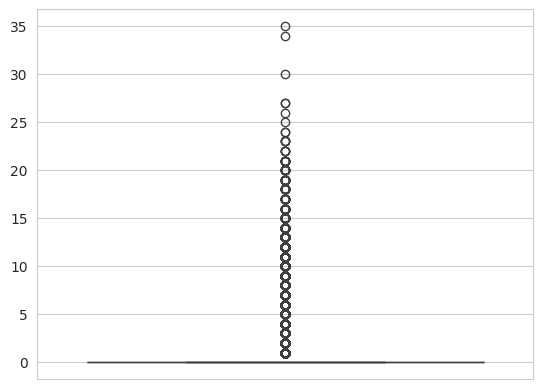

In [28]:
sns.boxplot(activite["transactions_all"])

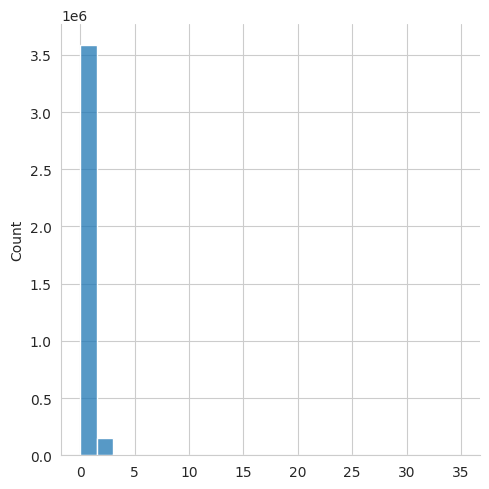

In [29]:
sns.displot(activite["transactions_all"])

### Analyse des dépot suivant les stations

In [30]:
ajout_by_station = activite.group_by("station_id").agg(
    [
        pl.col("transactions_all").max().alias("max"),
        pl.col("transactions_all").mean().alias("mean"),
        pl.col("transactions_all").median().alias("median"),
        pl.col("transactions_all").min().alias("min"),
        pl.col("transactions_all").std().alias("std"),
        pl.col("transactions_all").var().alias("var"),
        pl.col("transactions_all").skew().alias("skew"),
        pl.col("transactions_all").quantile(0.25).alias("25%"),
        pl.col("transactions_all").quantile(0.75).alias("75%"),
        pl.col("transactions_all").quantile(0.95).alias("95%"),
    ]
)

ajout_by_station = ajout_by_station.sort("mean", descending=True)

In [31]:
ajout_by_station

station_id,max,mean,median,min,std,var,skew,25%,75%,95%
u8,i8,f64,f64,i8,f64,f64,f64,f64,f64,f64
106,21,1.129741,1.0,0,1.578292,2.491007,3.315706,0.0,2.0,4.0
5,34,0.894912,1.0,0,1.326123,1.758603,4.066506,0.0,1.0,3.0
22,20,0.866327,0.0,0,1.218026,1.483588,2.689566,0.0,1.0,3.0
123,23,0.83358,0.0,0,1.418022,2.010788,4.35885,0.0,1.0,3.0
39,25,0.831175,0.0,0,1.296146,1.679994,3.545201,0.0,1.0,3.0
…,…,…,…,…,…,…,…,…,…,…
160,3,0.002359,0.0,0,0.062659,0.003926,32.039762,0.0,0.0,0.0
76,1,0.000093,0.0,0,0.009618,0.000093,103.956722,0.0,0.0,0.0
35,0,0.0,0.0,0,0.0,0.0,NaN,0.0,0.0,0.0


In [ ]:
# Station les plus active sur les dépôt de vélo
plot_station_activity(activite.to_pandas(), station_id=106, features_to_plot=["transactions_all"])

In [33]:
activite.head()

gid,station_id,type,name,state,available_stands,available_bikes,date,transactions_all
u8,u8,cat,str,str,i8,i8,datetime[μs],i8
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:03:04,0
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:04:04,0
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:09:04,0
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:14:03,0
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 00:19:04,0


In [39]:
from datetime import datetime

# activite[(activite.station_id == 5) & (activite.date >= "2017-08-28 05:20:00")]
activite.filter((pl.col("station_id") == 5) & (pl.col("date") >= datetime(2017, 8, 28, 5, 20, 0)))

gid,station_id,type,name,state,available_stands,available_bikes,date,transactions_all
u8,u8,cat,str,str,i8,i8,datetime[μs],i8
43,5,"""VLS""","""Place Gambetta""","""0""",36,3,2017-08-28 05:24:04,0
43,5,"""VLS""","""Place Gambetta""","""0""",36,3,2017-08-28 05:29:04,0
43,5,"""VLS""","""Place Gambetta""","""1""",12,3,2017-08-28 05:34:04,0
43,5,"""VLS""","""Place Gambetta""","""1""",3,37,2017-08-28 05:39:04,34
43,5,"""VLS""","""Place Gambetta""","""1""",3,37,2017-08-28 05:44:05,0
…,…,…,…,…,…,…,…,…
43,5,"""VLS""","""Place Gambetta""","""1""",14,25,2017-09-26 14:39:02,1
43,5,"""VLS""","""Place Gambetta""","""1""",14,25,2017-09-26 14:44:05,0
43,5,"""VLS""","""Place Gambetta""","""1""",15,24,2017-09-26 14:49:05,1


In [36]:
activite.collect_schema()

Schema([('gid', UInt8),
        ('station_id', UInt8),
        ('type', Categorical(ordering='physical')),
        ('name', String),
        ('state', String),
        ('available_stands', Int8),
        ('available_bikes', Int8),
        ('date', Datetime(time_unit='us', time_zone=None)),
        ('transactions_all', Int8)])

# Test

In [40]:
from vcub_keeper.transform.features_factory import get_transactions_all

In [41]:
# Lecture de l'activité des stations
activite = read_activity_vcub()

In [42]:
activite = get_transactions_all(activite)

In [43]:
activite["date"].min()

datetime.datetime(2017, 7, 9, 0, 3, 4)

In [47]:
activite.filter(pl.col("transactions_all") > 0).head(10)

gid,station_id,type,name,state,available_stands,available_bikes,date,transactions_all
u8,u8,cat,str,str,i8,i8,datetime[μs],i8
83,1,"""VLS""","""Meriadeck""","""1""",19,1,2017-07-09 00:24:05,1
83,1,"""VLS""","""Meriadeck""","""1""",20,0,2017-07-09 01:19:04,1
83,1,"""VLS""","""Meriadeck""","""1""",19,1,2017-07-09 03:24:05,1
83,1,"""VLS""","""Meriadeck""","""1""",18,2,2017-07-09 03:34:04,1
83,1,"""VLS""","""Meriadeck""","""1""",16,4,2017-07-09 03:49:03,2
83,1,"""VLS""","""Meriadeck""","""1""",17,3,2017-07-09 04:09:04,1
83,1,"""VLS""","""Meriadeck""","""1""",16,4,2017-07-09 04:44:04,1
83,1,"""VLS""","""Meriadeck""","""1""",15,5,2017-07-09 04:49:04,1
83,1,"""VLS""","""Meriadeck""","""1""",14,6,2017-07-09 04:59:05,1


In [16]:
# activite[(activite["transactions_out"] > 1) & (activite["date"] == "2017-07-09 11:09:04")].head()
# activite[(activite["date"] >= "'2017-07-09 03:24:05'") & (activite["station_id"] == 1)].head(11).to_dict(orient="list")
activite[(activite["date"] >= "2017-07-09 00:54:05") & (activite["station_id"] == 22)].head(11).to_dict(orient="list")

{'gid': [92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92],
 'station_id': [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22],
 'type': ['VLS',
  'VLS',
  'VLS',
  'VLS',
  'VLS',
  'VLS',
  'VLS',
  'VLS',
  'VLS',
  'VLS',
  'VLS'],
 'name': ['Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville',
  'Hotel de Ville'],
 'state': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'available_stands': [33, 33, 31, 33, 33, 33, 33, 32, 33, 33, 33],
 'available_bikes': [0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0],
 'date': [Timestamp('2017-07-09 00:54:05'),
  Timestamp('2017-07-09 00:59:04'),
  Timestamp('2017-07-09 01:04:04'),
  Timestamp('2017-07-09 01:09:03'),
  Timestamp('2017-07-09 01:14:04'),
  Timestamp('2017-07-09 01:19:04'),
  Timestamp('2017-07-09 01:24:04'),
  Timestamp('2017-07-09 01:29:04'),
  Timestamp('2017-07-09 01:34:04'),
  Timestamp('2017-07-09 01:39:04'),
  Timestamp('

In [ ]:
{
    "gid": [92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92],
    "station_id": [22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22],
    "type": ["VLS", "VLS", "VLS", "VLS", "VLS", "VLS", "VLS", "VLS", "VLS", "VLS", "VLS"],
    "name": [
        "Hotel de Ville",
        "Hotel de Ville",
        "Hotel de Ville",
        "Hotel de Ville",
        "Hotel de Ville",
        "Hotel de Ville",
        "Hotel de Ville",
        "Hotel de Ville",
        "Hotel de Ville",
        "Hotel de Ville",
        "Hotel de Ville",
    ],
    "state": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    "available_stands": [33, 33, 31, 33, 33, 33, 33, 32, 33, 33, 33],
    "available_bikes": [0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0],
    "date": [
        pd.Timestamp("2017-07-09 00:54:05"),
        pd.Timestamp("2017-07-09 00:59:04"),
        pd.Timestamp("2017-07-09 01:04:04"),
        pd.Timestamp("2017-07-09 01:09:03"),
        pd.Timestamp("2017-07-09 01:14:04"),
        pd.Timestamp("2017-07-09 01:19:04"),
        pd.Timestamp("2017-07-09 01:24:04"),
        pd.Timestamp("2017-07-09 01:29:04"),
        pd.Timestamp("2017-07-09 01:34:04"),
        pd.Timestamp("2017-07-09 01:39:04"),
        pd.Timestamp("2017-07-09 01:44:05"),
    ],
    "transactions_all": [2.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
}

In [20]:
data = {
    "gid": [83] * 11 + [92] * 11,
    "station_id": [1] * 11 + [22] * 11,
    "type": ["VLS"] * 11 + ["VLS"] * 11,
    "name": ["Meriadeck"] * 11 + ["Hotel de Ville"] * 11,
    "state": [1] * 11 + [1] * 11,
    "available_stands": [19, 19, 18, 18, 18, 16, 16, 16, 16, 17, 17] + [33, 33, 31, 33, 33, 33, 33, 32, 33, 33, 33],
    "available_bikes": [1, 1, 2, 2, 2, 4, 4, 4, 4, 3, 3] + [0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0],
    "date": [
        pd.Timestamp("2017-07-09 03:24:05"),
        pd.Timestamp("2017-07-09 03:29:04"),
        pd.Timestamp("2017-07-09 03:34:04"),
        pd.Timestamp("2017-07-09 03:39:04"),
        pd.Timestamp("2017-07-09 03:44:05"),
        pd.Timestamp("2017-07-09 03:49:03"),
        pd.Timestamp("2017-07-09 03:54:04"),
        pd.Timestamp("2017-07-09 03:59:03"),
        pd.Timestamp("2017-07-09 04:04:06"),
        pd.Timestamp("2017-07-09 04:09:04"),
        pd.Timestamp("2017-07-09 04:14:04"),
    ]
    + [
        pd.Timestamp("2017-07-09 00:54:05"),
        pd.Timestamp("2017-07-09 00:59:04"),
        pd.Timestamp("2017-07-09 01:04:04"),
        pd.Timestamp("2017-07-09 01:09:03"),
        pd.Timestamp("2017-07-09 01:14:04"),
        pd.Timestamp("2017-07-09 01:19:04"),
        pd.Timestamp("2017-07-09 01:24:04"),
        pd.Timestamp("2017-07-09 01:29:04"),
        pd.Timestamp("2017-07-09 01:34:04"),
        pd.Timestamp("2017-07-09 01:39:04"),
        pd.Timestamp("2017-07-09 01:44:05"),
    ],
    "transactions_all": [0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0]
    + [0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
}

df_activite = pd.DataFrame(data)
# drop columns we want to test.
df_activite = df_activite.drop(columns=["transactions_all"], axis=1)

result = get_transactions_all(df_activite)

expected = pd.DataFrame(data)

pd.testing.assert_frame_equal(result, expected)